# Modeling Translation in COBRAme

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Solve the model

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

In [4]:
solve_me_model(me, 1., min_mu = .1, precision=1e-2, using_soplex=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 67.946323 seconds
Finished substituting S,lb,ub in 4.763397 seconds
Finished makeME_LP in 0.810985 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 4.769142 seconds
Finished makeME_LP in 0.794520 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 4.740473 seconds
Finished makeME_LP in 0.790299 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 4.735799 seconds
Finished makeME_LP in 0.796387 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 4.730270 seconds
Finished makeME_LP in 0.795436 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 4.815599 seconds
Finished makeME_LP in 0.792704 seconds
Getting MINOS pa

## 4. Modeling the iJL1678b-ME (ECOLIme) Translation Process

A “TranslationReaction” includes all the metabolites required to transcribe the mRNA to a protein. A graphical overview of this reaction is shown below.

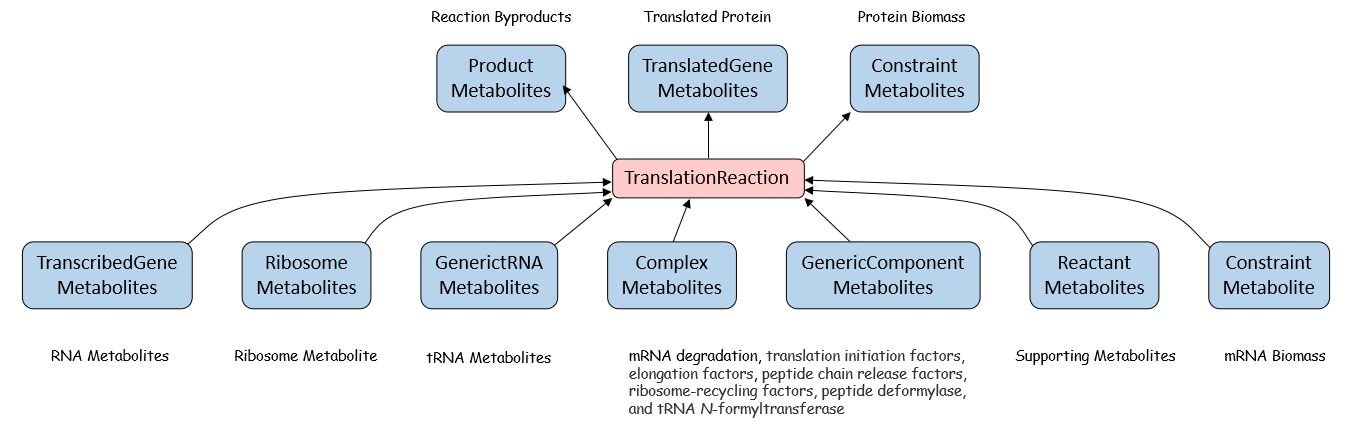

Let's start by creating a table that lists all the translation reactions in the model and their products.

In [5]:
model_translation_reactions = []
protein_products = []
temp = []
x = [r.id for r in me.reactions]
for r in x:
    # Find translation reactions
    if 'translation_' in r: 
        model_translation_reactions.append(r)
        y = [r.id for r in me.reactions.get_by_id(r).products]
        # Find protein products in translation reaction products
        for z in y: 
            if "_c" not in z and "biomass" not in z:
                temp.append(z)
        protein_products.append(temp)
        temp = []

# Create Pandas table
zipped = list(zip(model_translation_reactions, protein_products))
df = pd.DataFrame(zipped, columns=['Translation Reactions', 'Protein Products']).set_index('Translation Reactions')
df = df.loc[~(df==0).all(axis=1)] # removing reactions with zero flux
df

,Protein Products
Translation Reactions,
translation_b0002,[protein_b0002]
translation_b0003,[protein_b0003]
translation_b0004,[protein_b0004]
translation_b0007,[protein_b0007]
translation_b0008,[protein_b0008]
translation_b0009,[protein_b0009]
translation_b0014,[protein_b0014]
translation_b0015,[protein_b0015]
translation_b0019,[protein_b0019]


Now let's create a table that lists all the reactants associated with each transcription reaction.

In [6]:
pd.set_option('display.width', 2500)
pd.set_option('display.max_colwidth',2500)
translation_reactants = []
temp = []
for r in model_translation_reactions:
    temp.append(me.reactions.get_by_id(r).reactants)
    for s in temp:
        translation_reactants.append([r.id for r in s])
#TR_reactants

# Create Pandas table
zipped = list(zip(model_translation_reactions, translation_reactants))
df = pd.DataFrame(zipped, columns=['Translation Reactions', 'Translation Reaction Reactants']).set_index('Translation Reactions')
df = df.loc[~(df==0).all(axis=1)] # removing reactions with zero flux
df

,Translation Reaction Reactants
Translation Reactions,
translation_b0002,"[met__L_c, h2o_c, arg__L_c, val__L_c, leu__L_c, lys__L_c, phe__L_c, gly_c, thr__L_c, ser__L_c, ala__L_c, asn__L_c, glu__L_c, asp__L_c, ile__L_c, gln__L_c, pro__L_c, his__L_c, cys__L_c, tyr__L_c, trp__L_c, ribosome, RNA_b0002, atp_c, RNA_degradosome, generic_Tuf, gtp_c, generic_tRNA_AUG_met__L_c, generic_tRNA_CGA_arg__L_c, generic_tRNA_GUG_val__L_c, generic_tRNA_UUG_leu__L_c, generic_tRNA_AAG_lys__L_c, generic_tRNA_UUC_phe__L_c, generic_tRNA_GGC_gly_c, generic_tRNA_GGU_gly_c, generic_tRNA_ACA_thr__L_c, generic_tRNA_UCA_ser__L_c, generic_tRNA_GCA_ala__L_c, generic_tRNA_AAU_asn__L_c, generic_tRNA_GAA_glu__L_c, generic_tRNA_CGU_arg__L_c, generic_tRNA_UUU_phe__L_c, generic_tRNA_CUG_leu__L_c, generic_tRNA_GUU_val__L_c, generic_tRNA_GCC_ala__L_c, generic_tRNA_GAU_asp__L_c, generic_tRNA_AUU_ile__L_c, generic_tRNA_AGC_ser__L_c, generic_tRNA_AGG_arg__L_c, generic_tRNA_CAG_gln__L_c, generic_tRNA_GGG_gly_c, generic_tRNA_ACC_thr__L_c, generic_tRNA_GUC_val__L_c, generic_tRNA_CUC_leu__L_c, generic_tRNA_UCU_ser__L_c, generic_tRNA_CCC_pro__L_c, generic_tRNA_AAA_lys__L_c, generic_tRNA_AUC_ile__L_c, generic_tRNA_AAC_asn__L_c, generic_tRNA_CAC_his__L_c, generic_tRNA_GCG_ala__L_c, generic_tRNA_GCU_ala__L_c, generic_tRNA_UUA_leu__L_c, generic_tRNA_CUU_leu__L_c, generic_tRNA_ACG_thr__L_c, generic_tRNA_GGA_gly_c, generic_tRNA_CCG_pro__L_c, generic_tRNA_CAA_gln__L_c, generic_tRNA_ACU_thr__L_c, generic_tRNA_AUA_ile__L_c, generic_tRNA_CAU_his__L_c, generic_tRNA_AGU_ser__L_c, generic_tRNA_UGC_cys__L_c, generic_tRNA_GAG_glu__L_c, generic_tRNA_UCG_ser__L_c, generic_tRNA_GUA_val__L_c, generic_tRNA_CGC_arg__L_c, generic_tRNA_UAC_tyr__L_c, generic_tRNA_UCC_ser__L_c, generic_tRNA_GAC_asp__L_c, generic_tRNA_UGU_cys__L_c, generic_tRNA_UGG_trp__L_c, generic_tRNA_UAU_tyr__L_c, generic_tRNA_CCU_pro__L_c, generic_tRNA_CCA_pro__L_c, generic_tRNA_CGG_arg__L_c, generic_tRNA_CUA_leu__L_c, PrfB_mono, InfB_mono, Fmt_mono_mod_mg2_mod_k, 10fthf_c, generic_tRNA_START_met__L_c, InfA_mono, InfC_mono, FusA_mono, Tsf_mono, Rrf_mono, Def_mono_mod_1:fe2, PrfC_mono, mRNA_biomass]"
translation_b0003,"[met__L_c, h2o_c, arg__L_c, val__L_c, leu__L_c, lys__L_c, phe__L_c, gly_c, thr__L_c, ser__L_c, ala__L_c, asn__L_c, glu__L_c, asp__L_c, ile__L_c, gln__L_c, pro__L_c, his__L_c, cys__L_c, tyr__L_c, trp__L_c, ribosome, RNA_b0002, atp_c, RNA_degradosome, generic_Tuf, gtp_c, generic_tRNA_AUG_met__L_c, generic_tRNA_CGA_arg__L_c, generic_tRNA_GUG_val__L_c, generic_tRNA_UUG_leu__L_c, generic_tRNA_AAG_lys__L_c, generic_tRNA_UUC_phe__L_c, generic_tRNA_GGC_gly_c, generic_tRNA_GGU_gly_c, generic_tRNA_ACA_thr__L_c, generic_tRNA_UCA_ser__L_c, generic_tRNA_GCA_ala__L_c, generic_tRNA_AAU_asn__L_c, generic_tRNA_GAA_glu__L_c, generic_tRNA_CGU_arg__L_c, generic_tRNA_UUU_phe__L_c, generic_tRNA_CUG_leu__L_c, generic_tRNA_GUU_val__L_c, generic_tRNA_GCC_ala__L_c, generic_tRNA_GAU_asp__L_c, generic_tRNA_AUU_ile__L_c, generic_tRNA_AGC_ser__L_c, generic_tRNA_AGG_arg__L_c, generic_tRNA_CAG_gln__L_c, generic_tRNA_GGG_gly_c, generic_tRNA_ACC_thr__L_c, generic_tRNA_GUC_val__L_c, generic_tRNA_CUC_leu__L_c, generic_tRNA_UCU_ser__L_c, generic_tRNA_CCC_pro__L_c, generic_tRNA_AAA_lys__L_c, generic_tRNA_AUC_ile__L_c, generic_tRNA_AAC_asn__L_c, generic_tRNA_CAC_his__L_c, generic_tRNA_GCG_ala__L_c, generic_tRNA_GCU_ala__L_c, generic_tRNA_UUA_leu__L_c, generic_tRNA_CUU_leu__L_c, generic_tRNA_ACG_thr__L_c, generic_tRNA_GGA_gly_c, generic_tRNA_CCG_pro__L_c, generic_tRNA_CAA_gln__L_c, generic_tRNA_ACU_thr__L_c, generic_tRNA_AUA_ile__L_c, generic_tRNA_CAU_his__L_c, generic_tRNA_AGU_ser__L_c, generic_tRNA_UGC_cys__L_c, generic_tRNA_GAG_glu__L_c, generic_tRNA_UCG_ser__L_c, generic_tRNA_GUA_val__L_c, generic_tRNA_CGC_arg__L_c, generic_tRNA_UAC_tyr__L_c, generic_tRNA_UCC_ser__L_c, generic_tRNA_GAC_asp__L_c, generic_tRNA_UGU_cys__L_c, generic_tRNA_UGG_trp__L_c, generic_tRNA_UAU_tyr__L_c, generic_tRNA_CCU_pro__L_c, generic_tRNA_CCA_pro__L_c, generic_tRNA_CGG_arg_

Creating a list of the supporting metabolites (reactants) that does not include the amino acids or charged tRNA metabolites

In [7]:
import itertools
translation_min_reactants = []
temp = []
temp2 = []
w = []
for r in model_translation_reactions:
    y = me.reactions.get_by_id(r).reactants
    temp2.append([x.id for x in y])
    temp = list(itertools.chain(*temp2)) # Flatten the list
    for z in temp:
        if ('_c' not in z) and ('biomass' not in z):
            w.append(z)
    w.sort()
    translation_min_reactants.append(w)
    temp = []
    temp2 = []
    w = []
# Create Pandas table
zipped = list(zip(model_translation_reactions, translation_min_reactants))
df = pd.DataFrame(zipped, columns=['Translation Reactions', 'Translation Reaction Reactants']).set_index('Translation Reactions')
df = df.loc[~(df==0).all(axis=1)] # removing reactions with zero flux
df

,Translation Reaction Reactants
Translation Reactions,
translation_b0002,"[Def_mono_mod_1:fe2, Fmt_mono_mod_mg2_mod_k, FusA_mono, InfA_mono, InfB_mono, InfC_mono, PrfB_mono, PrfC_mono, RNA_b0002, RNA_degradosome, Rrf_mono, Tsf_mono, generic_Tuf, ribosome]"
translation_b0003,"[Def_mono_mod_1:fe2, Fmt_mono_mod_mg2_mod_k, FusA_mono, InfA_mono, InfB_mono, InfC_mono, PrfC_mono, RNA_b0003, RNA_degradosome, Rrf_mono, Tsf_mono, generic_RF, generic_Tuf, ribosome]"
translation_b0004,"[Def_mono_mod_1:fe2, Fmt_mono_mod_mg2_mod_k, FusA_mono, InfA_mono, InfB_mono, InfC_mono, PrfC_mono, RNA_b0004, RNA_degradosome, Rrf_mono, Tsf_mono, generic_RF, generic_Tuf, ribosome]"
translation_b0007,"[Def_mono_mod_1:fe2, Fmt_mono_mod_mg2_mod_k, FusA_mono, InfA_mono, InfB_mono, InfC_mono, PrfC_mono, RNA_b0007, RNA_degradosome, Rrf_mono, Tsf_mono, generic_RF, generic_Tuf, ribosome]"
translation_b0008,"[Def_mono_mod_1:fe2, DnaJ_dim_mod_4:zn2, DnaK_mono, Fmt_mono_mod_mg2_mod_k, FusA_mono, GrpE_dim, InfA_mono, InfB_mono, InfC_mono, Map_mono_mod_2:fe2, PrfC_mono, RNA_b0008, RNA_degradosome, Rrf_mono, Tsf_mono, generic_RF, generic_Tuf, ribosome]"
translation_b0009,"[Def_mono_mod_1:fe2, Fmt_mono_mod_mg2_mod_k, FusA_mono, InfA_mono, InfB_mono, InfC_mono, PrfC_mono, RNA_b0009, RNA_degradosome, Rrf_mono, Tsf_mono, generic_RF, generic_Tuf, ribosome]"
translation_b0014,"[Def_mono_mod_1:fe2, Fmt_mono_mod_mg2_mod_k, FusA_mono, GroL_14, InfA_mono, InfB_mono, InfC_mono, Map_mono_mod_2:fe2, PrfC_mono, RNA_b0014, RNA_degradosome, Rrf_mono, Tsf_mono, cisGroES_hepta, generic_RF, generic_Tuf, ribosome, transGroES_hepta]"
translation_b0015,"[Def_mono_mod_1:fe2, Fmt_mono_mod_mg2_mod_k, FusA_mono, GroL_14, InfA_mono, InfB_mono, InfC_mono, Map_mono_mod_2:fe2, PrfC_mono, RNA_b0015, RNA_degradosome, Rrf_mono, Tsf_mono, cisGroES_hepta, generic_RF, generic_Tuf, ribosome, transGroES_hepta]"
translation_b0019,"[Def_mono_mod_1:fe2, Fmt_mono_mod_mg2_mod_k, FusA_mono, InfA_mono, InfB_mono, InfC_mono, PrfB_mono, PrfC_mono, RNA_b0019, RNA_degradosome, Rrf_mono, Tsf_mono, generic_Tuf, ribosome]"


List the charged tRNA metabolites associated with each "TranslationReaction"

In [8]:
charged_tRNA = []
temp = []
temp2 = []
w = []
for r in model_translation_reactions:
    y = me.reactions.get_by_id(r).reactants
    temp2.append([x.id for x in y])
    temp = list(itertools.chain(*temp2)) # Flatten the list
    for z in temp:
        if ('tRNA' in z):
            w.append(z)
    w.sort()
    charged_tRNA.append(w)
    temp = []
    temp2 = []
    w = []
# Create Pandas table
zipped = list(zip(model_translation_reactions, charged_tRNA))
df_tRNA = pd.DataFrame(zipped, columns=['Translation Reactions', 'Charged tRNA Reations']).set_index('Translation Reactions')
df_tRNA = df_tRNA.loc[~(df==0).all(axis=1)] # removing reactions with zero flux
df_tRNA

,Charged tRNA Reations
Translation Reactions,
translation_b0002,"[generic_tRNA_AAA_lys__L_c, generic_tRNA_AAC_asn__L_c, generic_tRNA_AAG_lys__L_c, generic_tRNA_AAU_asn__L_c, generic_tRNA_ACA_thr__L_c, generic_tRNA_ACC_thr__L_c, generic_tRNA_ACG_thr__L_c, generic_tRNA_ACU_thr__L_c, generic_tRNA_AGC_ser__L_c, generic_tRNA_AGG_arg__L_c, generic_tRNA_AGU_ser__L_c, generic_tRNA_AUA_ile__L_c, generic_tRNA_AUC_ile__L_c, generic_tRNA_AUG_met__L_c, generic_tRNA_AUU_ile__L_c, generic_tRNA_CAA_gln__L_c, generic_tRNA_CAC_his__L_c, generic_tRNA_CAG_gln__L_c, generic_tRNA_CAU_his__L_c, generic_tRNA_CCA_pro__L_c, generic_tRNA_CCC_pro__L_c, generic_tRNA_CCG_pro__L_c, generic_tRNA_CCU_pro__L_c, generic_tRNA_CGA_arg__L_c, generic_tRNA_CGC_arg__L_c, generic_tRNA_CGG_arg__L_c, generic_tRNA_CGU_arg__L_c, generic_tRNA_CUA_leu__L_c, generic_tRNA_CUC_leu__L_c, generic_tRNA_CUG_leu__L_c, generic_tRNA_CUU_leu__L_c, generic_tRNA_GAA_glu__L_c, generic_tRNA_GAC_asp__L_c, generic_tRNA_GAG_glu__L_c, generic_tRNA_GAU_asp__L_c, generic_tRNA_GCA_ala__L_c, generic_tRNA_GCC_ala__L_c, generic_tRNA_GCG_ala__L_c, generic_tRNA_GCU_ala__L_c, generic_tRNA_GGA_gly_c, generic_tRNA_GGC_gly_c, generic_tRNA_GGG_gly_c, generic_tRNA_GGU_gly_c, generic_tRNA_GUA_val__L_c, generic_tRNA_GUC_val__L_c, generic_tRNA_GUG_val__L_c, generic_tRNA_GUU_val__L_c, generic_tRNA_START_met__L_c, generic_tRNA_UAC_tyr__L_c, generic_tRNA_UAU_tyr__L_c, generic_tRNA_UCA_ser__L_c, generic_tRNA_UCC_ser__L_c, generic_tRNA_UCG_ser__L_c, generic_tRNA_UCU_ser__L_c, generic_tRNA_UGC_cys__L_c, generic_tRNA_UGG_trp__L_c, generic_tRNA_UGU_cys__L_c, generic_tRNA_UUA_leu__L_c, generic_tRNA_UUC_phe__L_c, generic_tRNA_UUG_leu__L_c, generic_tRNA_UUU_phe__L_c]"
translation_b0003,"[generic_tRNA_AAA_lys__L_c, generic_tRNA_AAC_asn__L_c, generic_tRNA_AAG_lys__L_c, generic_tRNA_AAU_asn__L_c, generic_tRNA_ACA_thr__L_c, generic_tRNA_ACC_thr__L_c, generic_tRNA_ACG_thr__L_c, generic_tRNA_ACU_thr__L_c, generic_tRNA_AGC_ser__L_c, generic_tRNA_AGG_arg__L_c, generic_tRNA_AGU_ser__L_c, generic_tRNA_AUC_ile__L_c, generic_tRNA_AUG_met__L_c, generic_tRNA_AUU_ile__L_c, generic_tRNA_CAA_gln__L_c, generic_tRNA_CAC_his__L_c, generic_tRNA_CAG_gln__L_c, generic_tRNA_CAU_his__L_c, generic_tRNA_CCA_pro__L_c, generic_tRNA_CCC_pro__L_c, generic_tRNA_CCG_pro__L_c, generic_tRNA_CCU_pro__L_c, generic_tRNA_CGA_arg__L_c, generic_tRNA_CGC_arg__L_c, generic_tRNA_CGG_arg__L_c, generic_tRNA_CGU_arg__L_c, generic_tRNA_CUC_leu__L_c, generic_tRNA_CUG_leu__L_c, generic_tRNA_CUU_leu__L_c, generic_tRNA_GAA_glu__L_c, generic_tRNA_GAC_asp__L_c, generic_tRNA_GAG_glu__L_c, generic_tRNA_GAU_asp__L_c, generic_tRNA_GCA_ala__L_c, generic_tRNA_GCC_ala__L_c, generic_tRNA_GCG_ala__L_c, generic_tRNA_GCU_ala__L_c, generic_tRNA_GGA_gly_c, generic_tRNA_GGC_gly_c, generic_tRNA_GGG_gly_c, generic_tRNA_GGU_gly_c, generic_tRNA_GUA_val__L_c, generic_tRNA_GUC_val__L_c, generic_tRNA_GUG_val__L_c, generic_tRNA_GUU_val__L_c, generic_tRNA_START_met__L_c, generic_tRNA_UAC_tyr__L_c, generic_tRNA_UAU_tyr__L_c, generic_tRNA_UCA_ser__L_c, generic_tRNA_UCC_ser__L_c, generic_tRNA_UCG_ser__L_c, generic_tRNA_UGC_cys__L_c, generic_tRNA_UGG_trp__L_c, generic_tRNA_UGU_cys__L_c, generic_tRNA_UUA_leu__L_c, generic_tRNA_UUC_phe__L_c, generic_tRNA_UUG_leu__L_c, generic_tRNA_UUU_phe__L_c]"
translation_b0004,"[generic_tRNA_AAA_lys__L_c, generic_tRNA_AAC_asn__L_c, generic_tRNA_AAG_lys__L_c, generic_tRNA_AAU_asn__L_c, generic_tRNA_ACA_thr__L_c, generic_tRNA_ACC_thr__L_c, generic_tRNA_ACG_thr__L_c, generic_tRNA_ACU_thr__L_c, generic_tRNA_AGC_ser__L_c, generic_tRNA_AGU_ser__L_c, generic_tRNA_AUC_ile__L_c, generic_tRNA_AUG_met__L_c, generic_tRNA_AUU_ile__L_c, generic_tRNA_CAA_gln__L_c, generic_tRNA_CAC_his__L_c, generic_tRNA_CAG_gln__L_c, generic_tRNA_CAU_his__L_c, generic_tRNA_CCA_pro__L_c, generic_tRNA_CCC_pro__L_c, generic_tRNA_CCG_pro__L_c, generic_tRNA_CGA_arg__L_c, generic_tRNA_CGC_arg__L_c, generic_tRNA_CGU_arg__L_c, generic_tRNA_CUA_leu__L_c, generic_tRNA_CUC_leu__L_c, generic_tRNA_CUG_leu__L_

List all the charged tRNA metabolites available to the "TranslationReactions"

In [9]:
charged_tRNA = []
temp = []
temp2 = []
w = []
for r in model_translation_reactions:
    y = me.reactions.get_by_id(r).reactants
    temp2.append([x.id for x in y])
    temp = list(itertools.chain(*temp2)) # Flatten the list
    for z in temp:
        if ('tRNA' in z):
            w.append(z)
    w.sort()
    charged_tRNA.append(w)
    temp = []
    temp2 = []
    w = []
    
z = list(itertools.chain(*charged_tRNA))    
charged_tRNA_metabolites = list(set(z))
charged_tRNA_metabolites.sort()
charged_tRNA_metabolites

['generic_tRNA_AAA_lys__L_c',
 'generic_tRNA_AAC_asn__L_c',
 'generic_tRNA_AAG_lys__L_c',
 'generic_tRNA_AAU_asn__L_c',
 'generic_tRNA_ACA_thr__L_c',
 'generic_tRNA_ACC_thr__L_c',
 'generic_tRNA_ACG_thr__L_c',
 'generic_tRNA_ACU_thr__L_c',
 'generic_tRNA_AGA_arg__L_c',
 'generic_tRNA_AGC_ser__L_c',
 'generic_tRNA_AGG_arg__L_c',
 'generic_tRNA_AGU_ser__L_c',
 'generic_tRNA_AUA_ile__L_c',
 'generic_tRNA_AUC_ile__L_c',
 'generic_tRNA_AUG_met__L_c',
 'generic_tRNA_AUU_ile__L_c',
 'generic_tRNA_CAA_gln__L_c',
 'generic_tRNA_CAC_his__L_c',
 'generic_tRNA_CAG_gln__L_c',
 'generic_tRNA_CAU_his__L_c',
 'generic_tRNA_CCA_pro__L_c',
 'generic_tRNA_CCC_pro__L_c',
 'generic_tRNA_CCG_pro__L_c',
 'generic_tRNA_CCU_pro__L_c',
 'generic_tRNA_CGA_arg__L_c',
 'generic_tRNA_CGC_arg__L_c',
 'generic_tRNA_CGG_arg__L_c',
 'generic_tRNA_CGU_arg__L_c',
 'generic_tRNA_CUA_leu__L_c',
 'generic_tRNA_CUC_leu__L_c',
 'generic_tRNA_CUG_leu__L_c',
 'generic_tRNA_CUU_leu__L_c',
 'generic_tRNA_GAA_glu__L_c',
 'generic_

## 5. Example of the Translation Process

Let's begin by looking at the required reactants and products of "TranslationReactions". We will use the reactions "translation_b0002" which corresponds to thrA (fused aspartate kinase/homoserine dehydrogenase 1) as our example.

The product metabolites with their metabolite classification

In [10]:
me.reactions.get_by_id('translation_b0002').products

[<Metabolite ump_c at 0x7f4dae2dc668>,
 <Metabolite amp_c at 0x7f4dae2dc748>,
 <Metabolite cmp_c at 0x7f4dae2dc828>,
 <Metabolite gmp_c at 0x7f4dae2dc908>,
 <Metabolite adp_c at 0x7f4dae2b4b38>,
 <Metabolite pi_c at 0x7f4dae2b4c18>,
 <Metabolite h_c at 0x7f4dae2b4cf8>,
 <TranslatedGene protein_b0002 at 0x7f4dad5c2b00>,
 <Metabolite gdp_c at 0x7f4dad5c2b38>,
 <Metabolite ppi_c at 0x7f4dae2be0b8>,
 <Metabolite thf_c at 0x7f4dad5dc9b0>,
 <Metabolite for_c at 0x7f4dad5dce10>,
 <Constraint protein_biomass at 0x7f4dae3d5080>]

Simplifying to just list the product metabolites

In [11]:
x = me.reactions.get_by_id('translation_b0002').products
products = [r.id for r in x]
products

['ump_c',
 'amp_c',
 'cmp_c',
 'gmp_c',
 'adp_c',
 'pi_c',
 'h_c',
 'protein_b0002',
 'gdp_c',
 'ppi_c',
 'thf_c',
 'for_c',
 'protein_biomass']

The reactant metabolites with their metabolite classification

In [12]:
me.reactions.get_by_id('translation_b0002').reactants

[<Metabolite met__L_c at 0x7f4dad5b3940>,
 <Metabolite h2o_c at 0x7f4dae2b4a20>,
 <Metabolite arg__L_c at 0x7f4dad5b3a58>,
 <Metabolite val__L_c at 0x7f4dad5b3b38>,
 <Metabolite leu__L_c at 0x7f4dad5b3b00>,
 <Metabolite lys__L_c at 0x7f4dad5b3c50>,
 <Metabolite phe__L_c at 0x7f4dad5b3c88>,
 <Metabolite gly_c at 0x7f4dad5b3cc0>,
 <Metabolite thr__L_c at 0x7f4dad5b3dd8>,
 <Metabolite ser__L_c at 0x7f4dad5b3e80>,
 <Metabolite ala__L_c at 0x7f4dad5b3f28>,
 <Metabolite asn__L_c at 0x7f4dad5b3fd0>,
 <Metabolite glu__L_c at 0x7f4dad5c2080>,
 <Metabolite asp__L_c at 0x7f4dad5c2128>,
 <Metabolite ile__L_c at 0x7f4dad5c21d0>,
 <Metabolite gln__L_c at 0x7f4dad5c2240>,
 <Metabolite pro__L_c at 0x7f4dad5c22b0>,
 <Metabolite his__L_c at 0x7f4dad5c2358>,
 <Metabolite cys__L_c at 0x7f4dad5c23c8>,
 <Metabolite tyr__L_c at 0x7f4dad5c2438>,
 <Metabolite trp__L_c at 0x7f4dad5c24a8>,
 <Ribosome ribosome at 0x7f4dad5c2518>,
 <TranscribedGene RNA_b0002 at 0x7f4dae26d208>,
 <Metabolite atp_c at 0x7f4dae2b4940

Simplifying to just list the reactant metabolites

In [13]:
x = me.reactions.get_by_id('translation_b0002').reactants
reactants = [r.id for r in x]
reactants

['met__L_c',
 'h2o_c',
 'arg__L_c',
 'val__L_c',
 'leu__L_c',
 'lys__L_c',
 'phe__L_c',
 'gly_c',
 'thr__L_c',
 'ser__L_c',
 'ala__L_c',
 'asn__L_c',
 'glu__L_c',
 'asp__L_c',
 'ile__L_c',
 'gln__L_c',
 'pro__L_c',
 'his__L_c',
 'cys__L_c',
 'tyr__L_c',
 'trp__L_c',
 'ribosome',
 'RNA_b0002',
 'atp_c',
 'RNA_degradosome',
 'generic_Tuf',
 'gtp_c',
 'generic_tRNA_AUG_met__L_c',
 'generic_tRNA_CGA_arg__L_c',
 'generic_tRNA_GUG_val__L_c',
 'generic_tRNA_UUG_leu__L_c',
 'generic_tRNA_AAG_lys__L_c',
 'generic_tRNA_UUC_phe__L_c',
 'generic_tRNA_GGC_gly_c',
 'generic_tRNA_GGU_gly_c',
 'generic_tRNA_ACA_thr__L_c',
 'generic_tRNA_UCA_ser__L_c',
 'generic_tRNA_GCA_ala__L_c',
 'generic_tRNA_AAU_asn__L_c',
 'generic_tRNA_GAA_glu__L_c',
 'generic_tRNA_CGU_arg__L_c',
 'generic_tRNA_UUU_phe__L_c',
 'generic_tRNA_CUG_leu__L_c',
 'generic_tRNA_GUU_val__L_c',
 'generic_tRNA_GCC_ala__L_c',
 'generic_tRNA_GAU_asp__L_c',
 'generic_tRNA_AUU_ile__L_c',
 'generic_tRNA_AGC_ser__L_c',
 'generic_tRNA_AGG_arg__L_

An graphical outline of this translation reaction is

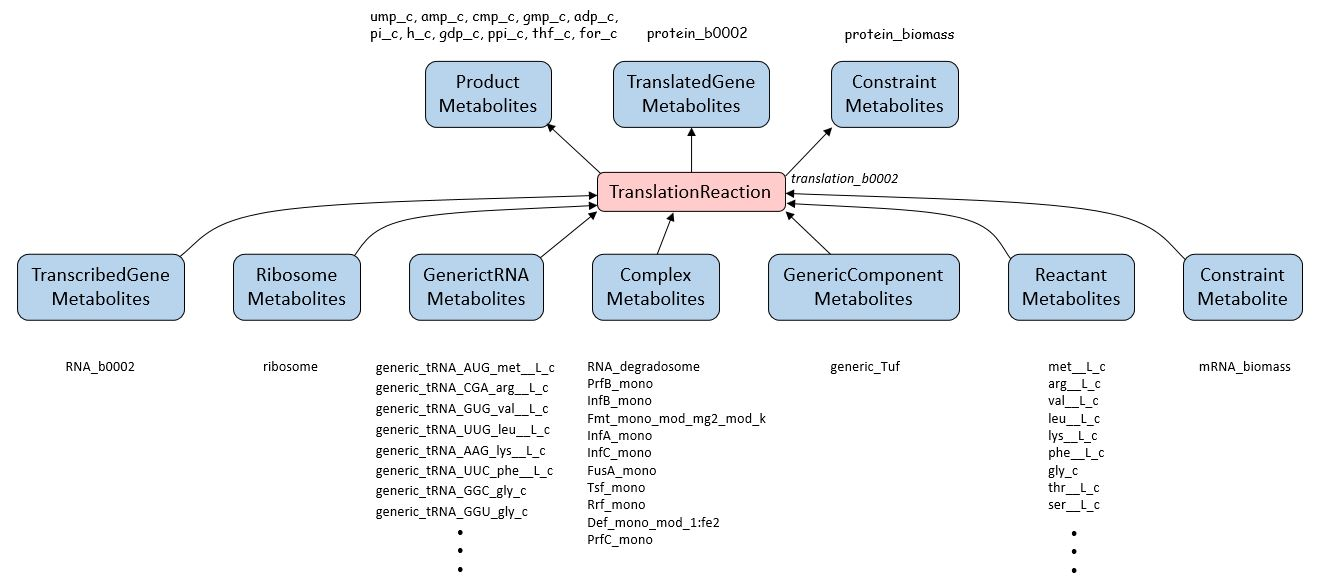

The total translation reaction for the b0002 gene is

In [14]:
me.reactions.get_by_id('translation_b0002').reaction

'10fthf_c + 2.72438972852433e-7*mu Def_mono_mod_1:fe2 + 1.80324164444648e-7*mu Fmt_mono_mod_mg2_mod_k + 0.0035*mu FusA_mono + 4.27350427350427e-6*mu InfA_mono + 4.45382843794892e-6*mu InfB_mono + 4.27350427350427e-6*mu InfC_mono + 1.63370183870619e-7*mu PrfB_mono + 4.27350427350427e-6*mu PrfC_mono + 0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_b0002 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 2.62130898398882e-7*mu Rrf_mono + 0.0035*mu Tsf_mono + 91 ala__L_c + 46 arg__L_c + 38 asn__L_c + 44 asp__L_c + 819.0 + 3.68117969821674*(mu + 0.3915)/mu atp_c + 12 cys__L_c + 0.0035*mu generic_Tuf + 22.0 generic_tRNA_AAA_lys__L_c + 16.0 generic_tRNA_AAC_asn__L_c + 12.0 generic_tRNA_AAG_lys__L_c + 22.0 generic_tRNA_AAU_asn__L_c + 2.0 generic_tRNA_ACA_thr__L_c + 19.0 generic_tRNA_ACC_thr__L_c + 8.0 generic_tRNA_ACG_thr__L_c + 5.0 generic_tRNA_ACU_thr__L_c + 12.0 generic_tRNA_AGC_ser__L_c + 2.0 generic_tRNA_AGG_arg__L_c + 3.0 generic_t

### Ribosome Formation 

The biosynthesis of a ribosome includes 94 reactant metabolites. An overview diagram of the formation_ribosome reaction is shown below.

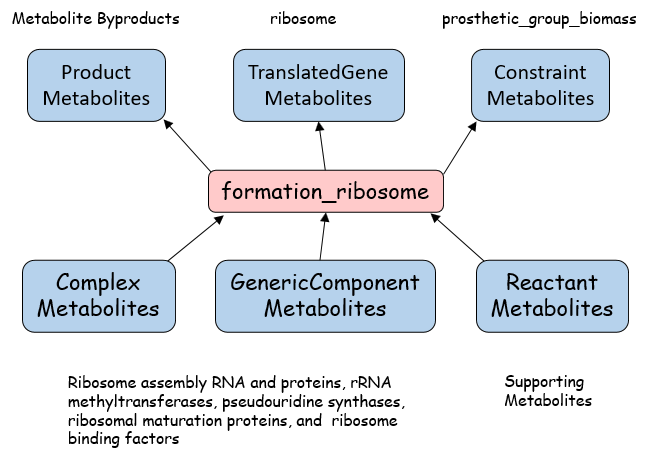

In [15]:
me.reactions.get_by_id('formation_ribosome').reactants

[<Complex RpsD_mono at 0x7f4dae2dc4a8>,
 <Complex RpsE_mono at 0x7f4da9817470>,
 <Complex RpsF_mono at 0x7f4da9a68908>,
 <Complex RpsG_mono at 0x7f4da9880828>,
 <Complex RpsH_mono at 0x7f4da98a2d68>,
 <Complex RpsI_mono at 0x7f4da9a16dd8>,
 <Complex RpsK_mono at 0x7f4da99e64e0>,
 <Complex RpsL_mono at 0x7f4da99892b0>,
 <Complex RpsM_mono at 0x7f4da980a320>,
 <Complex RpsO_mono at 0x7f4da994ed68>,
 <Complex RpsP_mono at 0x7f4da9a5b588>,
 <Complex RpsQ_mono at 0x7f4da97bb1d0>,
 <Complex RpsR_mono at 0x7f4da9996390>,
 <Complex RpsS_mono at 0x7f4da9938358>,
 <Complex RpsT_mono at 0x7f4da99154a8>,
 <GenericComponent generic_16s_rRNAs at 0x7f4da7ee3c50>,
 <Complex RpsA_mono at 0x7f4da988a7b8>,
 <Complex RpsB_mono at 0x7f4da9943518>,
 <Complex RpsC_mono at 0x7f4da980acc0>,
 <Complex RpsJ_mono at 0x7f4dae2dc470>,
 <Complex RpsN_mono at 0x7f4da99cfe80>,
 <Complex RpsU_mono at 0x7f4da9915f28>,
 <Complex Sra_mono at 0x7f4da97bbfd0>,
 <GenericComponent generic_23s_rRNAs at 0x7f4da7ee3fd0>,
 <Gener

The number of reactant metabolites is

In [16]:
len(me.reactions.get_by_id('formation_ribosome').reactants)

94

The products of the formation_ribosome reaction include

In [17]:
me.reactions.get_by_id('formation_ribosome').products

[<Constraint prosthetic_group_biomass at 0x7f4dae3d5438>,
 <Ribosome ribosome at 0x7f4dad5c2518>,
 <Metabolite ahcys_c at 0x7f4da9da8438>,
 <Metabolite h_c at 0x7f4dae2b4cf8>,
 <Metabolite nad_c at 0x7f4da97a2048>,
 <Metabolite pi_c at 0x7f4dae2b4c18>,
 <Metabolite gdp_c at 0x7f4dad5c2b38>]

### Translation Reaction Fluxes
List the non-zero fluxes flowing through the transcription reactions

In [18]:
translation_reactions = []
translation_reaction_flux = []
x = [r.id for r in me.reactions]
for r in x:
    if 'transcription_T' in r:
        translation_reactions.append(r)
        translation_reaction_flux.append(me.reactions.get_by_id(r).x)

# Create Pandas table
zipped = list(zip(translation_reactions, translation_reaction_flux))
df = pd.DataFrame(zipped, columns=['Translation Reactions', 'Translationn Reaction Flux']).set_index('Translation Reactions')
df = df.loc[~(df==0).all(axis=1)] # removing reactions with zero flux
df

,Translationn Reaction Flux
Translation Reactions,
transcription_TU0_8529_from_RpoD_mono,1.136100e-11
transcription_TU0_8464_from_RpoD_mono,2.302526e-06
transcription_TU0_13006_from_RpoD_mono,3.244344e-14
transcription_TU0_5003_from_RPOH_MONOMER,2.728023e-10
transcription_TU0_3423_from_RPOE_MONOMER,3.448065e-08
transcription_TU00429_from_RpoD_mono,1.707059e-08
transcription_TU00293_from_RpoD_mono,8.921349e-11
transcription_TU0_3424_from_RPOE_MONOMER,6.515644e-08
transcription_TU00369_from_RpoD_mono,2.109657e-11
